In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import seaborn as sns
import statsmodels.api as sm

# Data wrangling and exploration

We begin by loading the two data sets and looking at the different attributes. We decide to add two columns **Movie release year** and **Actor birth year**.

In [10]:
# Load datasets
headers_character_metadata = ['Wikipedia Movie ID', 'Freebase Movie ID','Movie release date', 'Character name', 'Actor DOB', 
                              'Actor gender', 'Actor height', 'Actor ethnicity', 'Actor name',
                              'Actor age at movie release', 'Freebase character map', 'Freebase character ID', 'Freebase actor ID']
character_metadata = pd.read_csv('./data/character.metadata.tsv', sep='\t', names=headers_character_metadata)

movie_metadata = pd.read_csv('./modified_data/movie_metadata_TMDB_FINAL.csv', sep=',')

/var/folders/j2/9f4vw4v96p97ssvk4f1301sw0000gn/T/ipykernel_16741/1620376315.py:10: DtypeWarning: Columns (19,20) have mixed types. Specify dtype option on import or set low_memory=False.
  movie_metadata = pd.read_csv('./modified_data/movie_metadata_TMDB_FINAL.csv', sep=',')#, names=headers_movie_metadata)


In [19]:
# Rename 'Movie box office revenue enriched' to Movie box office revenue' for to match previous column name
movie_metadata = movie_metadata.rename(columns={'Movie box office revenue enriched': 'Movie box office revenue'})

In [20]:
# Add a column of release year to get consistency
character_metadata['Movie release year'] = character_metadata['Movie release date'].str.split('-').str[0].astype('float')
movie_metadata['Movie release year'] = movie_metadata['Movie release date'].str.split('-').str[0].astype('float')

# Add a column of birth year to get consistency
character_metadata['Actor birth year'] = character_metadata['Actor DOB'].str.split('-').str[0].astype('float')


In [37]:
character_metadata

,Wikipedia Movie ID,Freebase Movie ID,Movie release date,Character name,Actor DOB,Actor gender,Actor height,Actor ethnicity,Actor name,Actor age at movie release,Freebase character map,Freebase character ID,Freebase actor ID,Movie release year,Actor birth year
0,975900,/m/03vyhn,2001-08-24,Akooshay,1958-08-26,F,1.620,NaN,Wanda De Jesus,42.0,/m/0bgchxw,/m/0bgcj3x,/m/03wcfv7,2001.0,1958.0
1,975900,/m/03vyhn,2001-08-24,Lieutenant Melanie Ballard,1974-08-15,F,1.780,/m/044038p,Natasha Henstridge,27.0,/m/0jys3m,/m/0bgchn4,/m/0346l4,2001.0,1974.0
2,975900,/m/03vyhn,2001-08-24,Desolation Williams,1969-06-15,M,1.727,/m/0x67,Ice Cube,32.0,/m/0jys3g,/m/0bgchn_,/m/01vw26l,2001.0,1969.0
3,975900,/m/03vyhn,2001-08-24,Sgt Jericho Butler,1967-09-12,M,1.750,NaN,Jason Statham,33.0,/m/02vchl6,/m/0bgchnq,/m/034hyc,2001.0,1967.0
4,975900,/m/03vyhn,2001-08-24,Bashira Kincaid,1977-09-25,F,1.650,NaN,Clea DuVall,23.0,/m/02vbb3r,/m/0bgchp9,/m/01y9xg,2001.0,1977.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
450664,913762,/m/03pcrp,1992-05-21,Elensh,1970-05,F,NaN,NaN,Dorothy Elias-Fahn,NaN,/m/0kr406c,/m/0kr406h,/m/0b_vcv,1992.0,1970.0
450665,913762,/m/03pcrp,1992-05-21,Hibiki,1965-04-12,M,NaN,NaN,Jonathan Fahn,27.0,/m/0kr405_,/m/0kr4090,/m/0bx7_j,1992.0,1965.0
450666,28308153,/m/0cp05t9,1957,NaN,1941-11-18,M,1.730,/m/02w7gg,David Hemmings,15.0,/m/0g8ngmc,NaN,/m/022g44,1957.0,1941.0
450667,28308153,/m/0cp05t9,1957,NaN,NaN,NaN,NaN,NaN,Roberta Paterson,NaN,/m/0g8ngmj,NaN,/m/0g8ngmm,1957.0,NaN


## Remove outliers

### Character dataset

Now we look more closely at each attribute and remove unrealistic values. We first take a look at **Movie release year**:

In [27]:
# Define function that print the minimum and maximum values of a defines variable in the data frame
def get_min_and_max(df, variable_name, no_min, no_max):
    array = df[variable_name].fillna(0).unique()
    sorted_array = np.sort(array)
    
    min_values = sorted_array[:no_min]
    max_values = sorted_array[-no_max:]
    
    print(f"{no_min} minimum values of '{variable_name}':")
    print(min_values)
    print('\n')
    print(f"{no_max} maximum values of '{variable_name}':")
    print(max_values)


In [28]:
# Find all unique years as sort them
get_min_and_max(df=character_metadata, variable_name='Movie release year', no_min=5, no_max=5)

5 minimum values of 'Movie release year':
[   0. 1010. 1888. 1891. 1893.]


5 maximum values of 'Movie release year':
[2012. 2013. 2014. 2015. 2016.]


We remove values below year 1800.

In [29]:
condition1 = (character_metadata['Movie release year'] < 1800)
condition2 = (movie_metadata['Movie release year'] < 1800)

character_metadata.loc[condition1, 'Movie release year'] = np.nan
movie_metadata.loc[condition2, 'Movie release year'] = np.nan

We now take a look at **Actor birth year**:

In [30]:
get_min_and_max(df=character_metadata, variable_name='Actor birth year', no_min=15, no_max=5)

15 minimum values of 'Actor birth year':
[   0.   19.  183.  195.  852. 1075. 1474. 1498. 1796. 1804. 1828. 1829.
 1835. 1836. 1837.]


5 maximum values of 'Actor birth year':
[2011. 2050. 2896. 2936. 9900.]


We see, that some birth years are unrealistic and decide to remove birth years, that are below 1700 and above 2016 (last movie release year).

In [31]:
# Define the condition to identify rows where 'Actor birth year' needs to be set to NaN
condition = (character_metadata['Actor birth year'] < 1700) | (character_metadata['Actor birth year'] > 2016)
character_metadata.loc[condition, 'Actor birth year'] = np.nan

We now look at **Actor height**:

In [32]:
get_min_and_max(df=character_metadata, variable_name='Actor height', no_min=15, no_max=15)

15 minimum values of 'Actor height':
[0.      0.61    0.813   0.83    0.88    0.94    1.      1.06    1.067
 1.07    1.09728 1.1176  1.12    1.14    1.143  ]


15 maximum values of 'Actor height':
[  2.11      2.13      2.134     2.16      2.161     2.18      2.2
   2.24      2.28      2.29      2.31      2.31648   2.356   180.
 510.     ]


Again, we remove unrealistic values, which are people with a height more than 2.4 meter. The people with small heights are probably kids, but we leave these for now.

In [33]:
# Define the condition to identify rows where height needs to be set to NaN
condition = (character_metadata['Actor height'] > 2.4)
character_metadata.loc[condition, 'Actor height'] = np.nan

We now look at **Actor age at movie release**:

In [34]:
get_min_and_max(df=character_metadata, variable_name='Actor age at movie release', no_min=20, no_max=20)

20 minimum values of 'Actor age at movie release':
[-7896.  -969.  -937.   -81.   -76.   -65.   -63.   -57.   -53.   -51.
   -50.   -48.   -47.   -44.   -43.   -42.   -39.   -38.   -37.   -36.]


20 maximum values of 'Actor age at movie release':
[ 80.  81.  82.  83.  84.  85.  86.  87.  88.  89.  90.  91.  92.  93.
  94.  95.  96.  97.  99. 103.]


We remove ages, that are less than 0 and higher than 110.

In [35]:
# Define the condition to identify rows where age needs to be set to NaN
condition = (character_metadata['Actor age at movie release'] < 0) | (character_metadata['Actor age at movie release'] > 110)
character_metadata.loc[condition, 'Actor age at movie release'] = np.nan

### Movie dataset

Let's begin by looking at **Movie runtime**:


In [38]:
get_min_and_max(df=movie_metadata, variable_name='Movie runtime', no_min=15, no_max=15)

15 minimum values of 'Movie runtime':
[0.         0.03       0.05       0.08333333 0.1        0.11666667
 0.15       0.2        0.21666667 0.26666667 0.3        0.33333333
 0.36666667 0.4        0.41666667]


15 maximum values of 'Movie runtime':
[   1440.      1530.      1533.      1560.      1620.      1966.
    2425.      2880.      4875.27    5100.      5220.      5700.
    9360.     14400.   1079281.  ]


We decide to only look at movies that have a maximum runtime of 5 hours.

In [39]:
condition = (movie_metadata['Movie runtime'] > 5*60)
movie_metadata.loc[condition, 'Movie runtime'] = np.nan

Now let's take a look at **Movie box office revenue**:

In [40]:
get_min_and_max(df=movie_metadata, variable_name='Movie box office revenue', no_min=10, no_max=10)

10 minimum values of 'Movie box office revenue':
[ 0.  1.  3.  5.  6. 10. 12. 13. 14. 15.]


10 maximum values of 'Movie box office revenue':
[1.06317191e+09 1.06565981e+09 1.07800895e+09 1.11992952e+09
 1.12374700e+09 1.32811122e+09 1.51175791e+09 2.18537230e+09
 2.78227517e+09 2.80000000e+09]


As the box office revenue can have a huge span, and we don't have any negative values, we leave this for now.

## Missing values

Let's look at the amount of missing values in our data. For each attribute, the percentage of missing values is calculated.

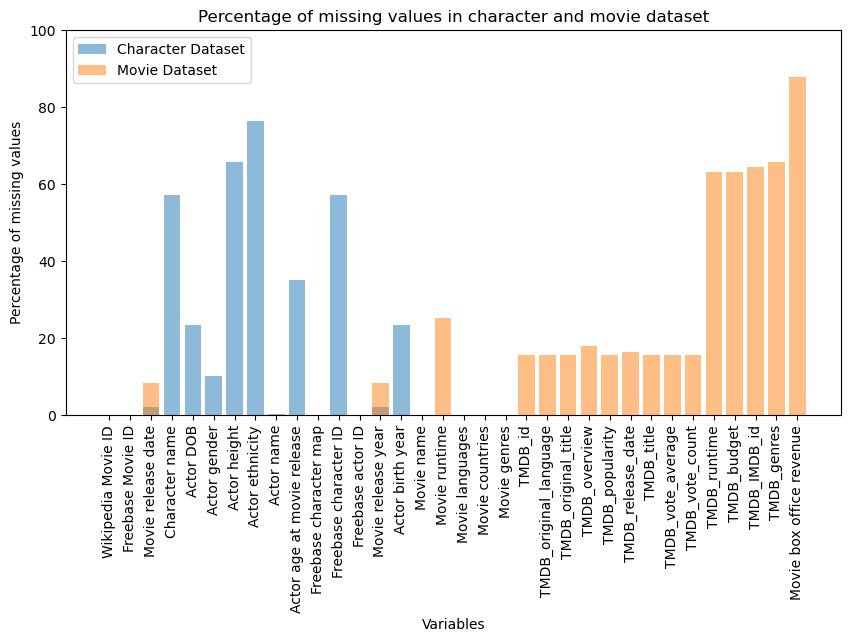

In [42]:
# Calculate percentage of missing values for each attribute
character_nan_percentages = character_metadata.isna().mean() * 100
movie_nan_percentages = movie_metadata.isna().mean() * 100

# Create a bar plot
fig, ax = plt.subplots(figsize=(10, 5))

# Plot the character dataset NaN percentages
ax.bar(character_nan_percentages.index, character_nan_percentages, label='Character Dataset', alpha=0.5)

# Plot the movie dataset NaN percentages
ax.bar(movie_nan_percentages.index, movie_nan_percentages, label='Movie Dataset', alpha=0.5)

ax.set_ylim(0,100)
ax.set_xlabel('Variables')
ax.set_ylabel('Percentage of missing values')
ax.set_title('Percentage of missing values in character and movie dataset')
ax.legend()
plt.xticks(rotation=90)
plt.show()

In [47]:
movie_metadata['Movie box office revenue'].count()

10018

As we can see, there is a lot of missing values for some of the attributes. Especially **Movie box office revenue** has a lot of missing values (around 90%). We have already enriched the this attribute with more data, but it is still lacking, Despite the amount of missing values, we decide to work with it, since this attribute still has around 10'000 data points.

Some character attributes like height and ethnicity are also missing.

## Distribution of variables in the character dataset

We now want to look at the distribution of the attributes of the characters metadata set. We divide the character dataset into male and female character dataset, and use box plots and histograms to look at the distribution on the attributes. We also perform a t-test for each of the attributes with the nul-hypothesis: there is no difference between male and female.

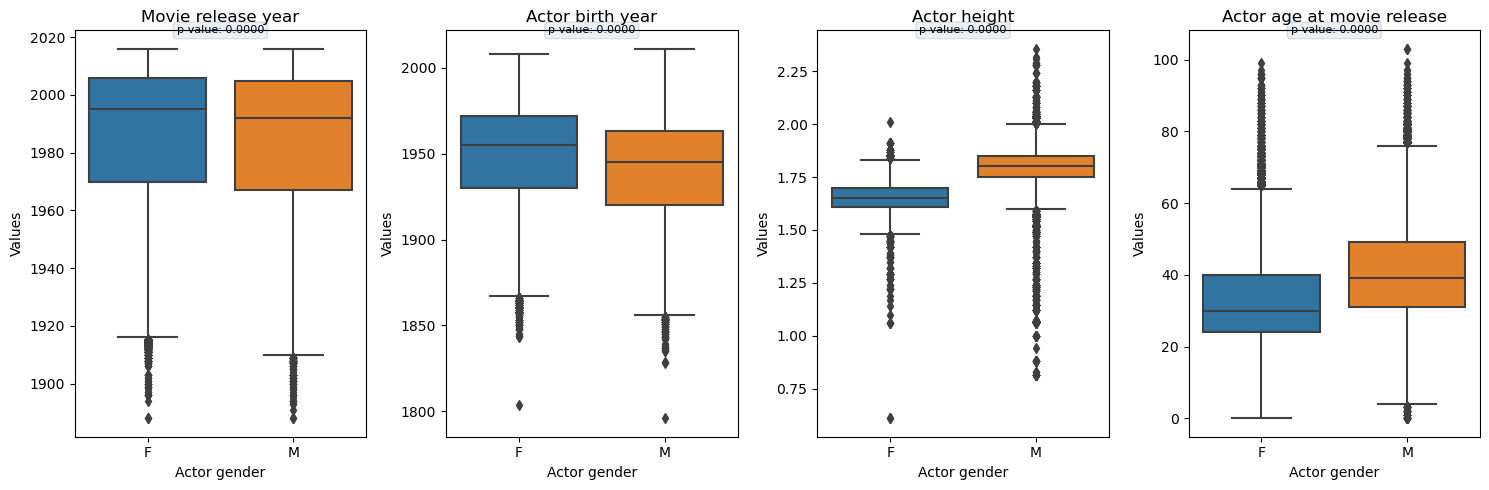

In [79]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from scipy import stats

# Assuming 'gender' is a column indicating the gender in your DataFrame
# 'character_metadata' is assumed to be your DataFrame

# Variables of interest
variables = ['Movie release year', 'Actor birth year', 'Actor height', 'Actor age at movie release']

# Create a figure with four subplots
fig, axes = plt.subplots(1, 4, figsize=(15, 5))

# Create box plots for each variable in each subplot
for i, variable in enumerate(variables):
    ax = axes[i]

    # Use sns.boxplot with 'Actor gender' as 'hue'
    sns.boxplot(x='Actor gender', y=variable, data=character_metadata, ax=ax)

    # Perform a t-test and get the p-value
    female_data = character_metadata[character_metadata['Actor gender'] == 'F'][variable].dropna()
    male_data = character_metadata[character_metadata['Actor gender'] == 'M'][variable].dropna()
    t_stat, p_value = stats.ttest_ind(female_data, male_data)

    # Annotate the plot with the p-value
    ax.annotate(f'p-value: {p_value:.4f}', xy=(0.5, max(ax.get_ylim())), ha='center', va='center',
                bbox=dict(boxstyle="round", alpha=0.1),
                fontsize=8, color='black')

    ax.set_ylabel('Values')
    ax.set_title(variable)

# Adjust the layout to prevent overlapping
plt.tight_layout()
plt.show()


The first box plots show us, that more movies have been released in the more revent years. Naturally, the birth years of the actor are also more recent therefore. These also show us, that there is a significant difference in **Movie release year** and **Actor birth year** for male and female actors, where female actors are more represented in recent years. We might want to log-transform these attributes, if they are used in further analysis.

The height attribute shows that there is significant difference between the height of male and female, which makes sense, since men are naturally taller than woman.

The last box plot shows us, that there is a significant difference in the **Actor age at movie release** for male and female actors. It indicates, that female actors generally are younger than male actors in movies.

We also look at the distributions with a histogram:

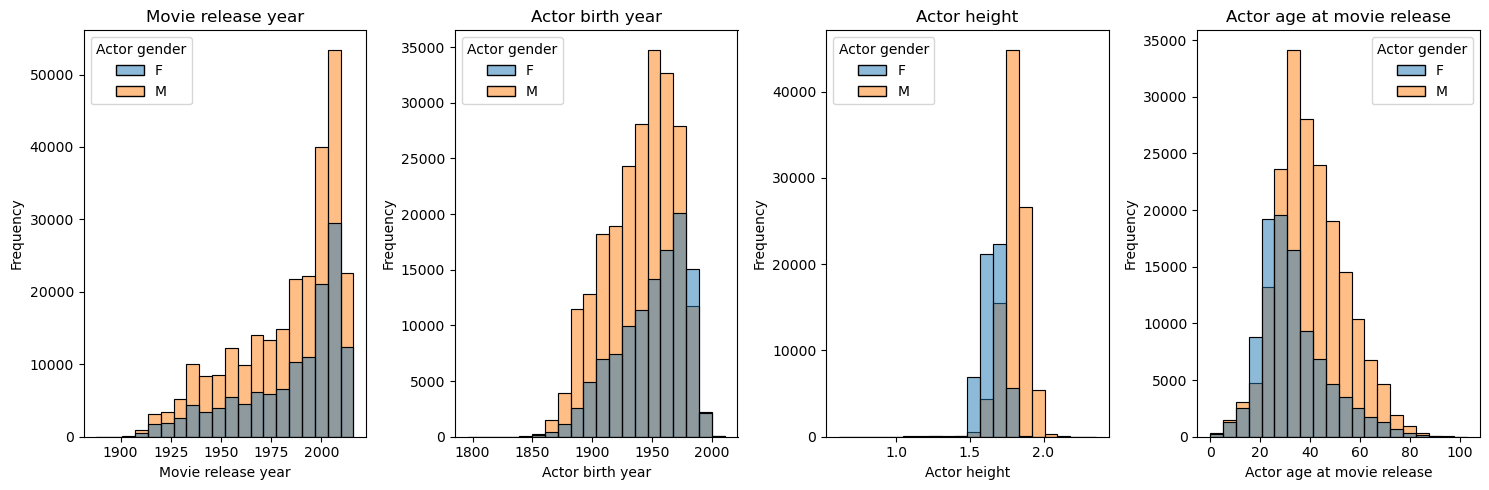

In [80]:
# Variables of interest
variables = ['Movie release year', 'Actor birth year', 'Actor height', 'Actor age at movie release']

# Create a figure with four subplots (one for each variable)
fig, axes = plt.subplots(1, 4, figsize=(15, 5))

# Create histograms for each variable in each subplot
for i, variable in enumerate(variables):
    ax = axes[i]

    # Create histograms for female and male characters for the current variable
    sns.histplot(data=character_metadata, x=variable, bins=20, alpha=0.5, hue='Actor gender', multiple='layer', ax=ax)

    ax.set_xlabel(variable)
    ax.set_ylabel('Frequency')
    ax.set_title(variable)

# Adjust the layout to prevent overlapping
plt.tight_layout()
plt.show()


The histogram backs up the claims made from the box plots.

We might want to

### Explore **Actor age at movie release**

To explore the statistical difference further, we look at the attribute **Actor age at movie release** throughout all the years for female and male characters.

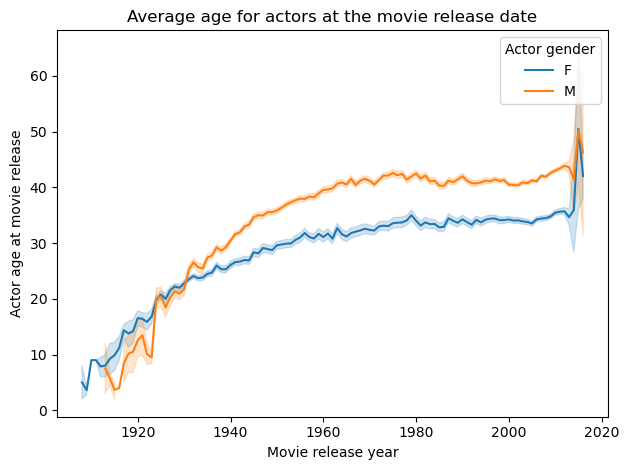

In [81]:
# Remove NaNs from relevant columns
character_metadata_nona = character_metadata[['Movie release year', 'Actor age at movie release', 'Actor gender']].dropna()
sns.lineplot(x='Movie release year', y='Actor age at movie release', data=character_metadata_nona, hue="Actor gender", err_style="band")

plt.title('Average age for actors at the movie release date')
plt.xlabel('Movie release year')
plt.ylabel('Actor age at movie release')
plt.tight_layout()
plt.show()


The plot is very strange up until around 1930. It seems that actors are very young (20 years or younger on average).

However, the plot shows that female actors are significantly younger than male actors from around year 1930 and forward.

##  Distribution of variables in the movies dataset

In [82]:
numerical_variables = ['Movie box office revenue', 'Movie runtime', 'Movie release year']

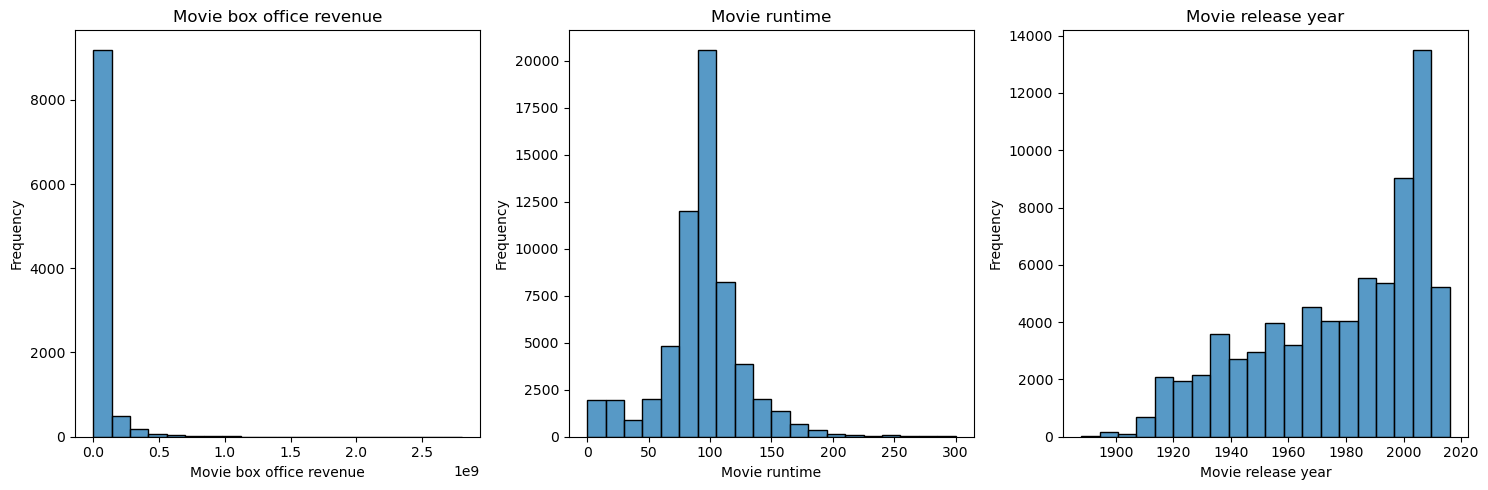

In [88]:
# Create a figure with four subplots (one for each variable)
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Create histograms for each variable in each subplot
for i, variable in enumerate(numerical_variables):
    ax = axes[i]

    # Create histograms for female and male characters for the current variable
    sns.histplot(data=movie_metadata, x=variable, ax=ax, bins=20)

    ax.set_xlabel(variable)
    ax.set_ylabel('Frequency')
    ax.set_title(variable)

# Adjust the layout to prevent overlapping
plt.tight_layout()
plt.show()

The plots show, that **Movie box office** has a highly right skewed distribution, also called a power law. We would need to transform this  attribute for further analysis.

The variable **Movie runtime* seem fairly normally distributed. The variable **Movie release year** is left skewed, so we will also try to apply a log transform to this.

In [91]:
movie_metadata['log Movie box office revenue'] = np.log(movie_metadata['Movie box office revenue'])

movie_metadata['log Movie release year'] = np.log(movie_metadata['Movie release year'])
character_metadata['log Movie release year'] = np.log(character_metadata['Movie release year'])

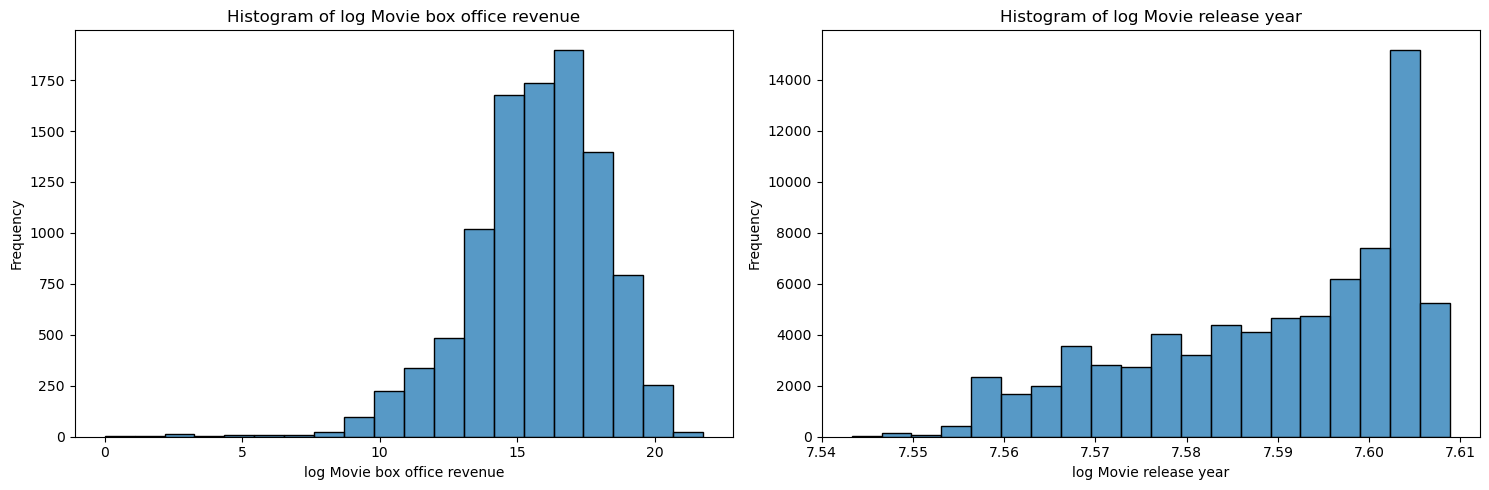

In [93]:
log_variables = ['log Movie box office revenue', 'log Movie release year']
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Create histograms for each variable in each subplot
for i, variable in enumerate(log_variables):
    ax = axes[i]

    # Create histograms for female and male characters for the current variable
    sns.histplot(data=movie_metadata, x=variable, ax=ax, bins=20)

    ax.set_xlabel(variable)
    ax.set_ylabel('Frequency')
    ax.set_title('Histogram of '+variable)

# Adjust the layout to prevent overlapping
plt.tight_layout()
plt.show()

After the log transform, **Movie box office revenue** is fairly normally distributed, but the log transform didn't do much for **Movie release year**, so we will keep this as it is.

### Categorical values

Let us take a look at the categorical values.

In [94]:
movie_metadata[['Movie genres', 'Movie languages', 'Movie countries']].head()

,Movie genres,Movie languages,Movie countries
0,"{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science...","{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}"
1,"{""/m/02n4kr"": ""Mystery"", ""/m/03bxz7"": ""Biograp...","{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}"
2,"{""/m/0lsxr"": ""Crime Fiction"", ""/m/07s9rl0"": ""D...","{""/m/05f_3"": ""Norwegian Language""}","{""/m/05b4w"": ""Norway""}"
3,"{""/m/01jfsb"": ""Thriller"", ""/m/0glj9q"": ""Erotic...","{""/m/02h40lc"": ""English Language""}","{""/m/07ssc"": ""United Kingdom""}"
4,"{""/m/07s9rl0"": ""Drama""}","{""/m/04306rv"": ""German Language""}","{""/m/0345h"": ""Germany""}"


We convert all the values for consistency and check all unique values.

In [95]:
# Function to extract genre names without Freebase codes
def extract_genre_names(genre_dict):
    genre_names = []
    for code, name in genre_dict.items():
        genre_names.append(name)
    return ", ".join(genre_names)

# Clean the "Movie genres" column
movie_metadata["Movie genres"] = movie_metadata["Movie genres"].apply(eval)  # Convert string representation of dictionary to actual dictionary
movie_metadata["Movie genres"] = movie_metadata["Movie genres"].apply(extract_genre_names)

# Clean the "Movie languages" column (assuming similar structure to genres column)
movie_metadata["Movie languages"] = movie_metadata["Movie languages"].apply(eval)
movie_metadata["Movie languages"] = movie_metadata["Movie languages"].apply(lambda x: ", ".join(x.values()))

# Clean the "Movie countries" column (assuming similar structure to genres column)
movie_metadata["Movie countries"] = movie_metadata["Movie countries"].apply(eval)
movie_metadata["Movie countries"] = movie_metadata["Movie countries"].apply(lambda x: ", ".join(x.values()))

In [96]:
genres = movie_metadata['Movie genres'].unique()

print(f"There are {len(genres)} different combinations genres.\n")
print(genres)

There are 23817 different combinations genres.

['Thriller, Science Fiction, Horror, Adventure, Supernatural, Action, Space western'
 'Mystery, Biographical film, Drama, Crime Drama' 'Crime Fiction, Drama'
 ... 'Crime Fiction, Thriller, Comedy, Supernatural'
 'Sports, Crime Fiction, Action, Drama'
 'Science Fiction, Japanese Movies, Adventure, Animation, Short Film, Anime, Drama']


In [97]:
languages = movie_metadata['Movie languages'].unique()

print(f"There are {len(languages)} different combinations languages.\n")
print(languages)

There are 1817 different combinations languages.

['English Language' 'Norwegian Language' 'German Language' ...
 'Hindi Language, Standard Tibetan, English Language'
 'Spanish Language, German Language, English Language, Hungarian language'
 'Italian Language, English Language, Norwegian Language']


In [98]:
countries = movie_metadata['Movie countries'].unique()

print(f"There are {len(countries)} different combinations of countries.\n")
print(countries)

There are 2124 different combinations of countries.

['United States of America' 'Norway' 'United Kingdom' ...
 'France, Switzerland, Algeria, Germany'
 'Kingdom of Great Britain, Japan, England, United Kingdom, Germany'
 'Switzerland, Italy, West Germany, German Democratic Republic']


## Further exploration

### Gender representation in movies

We now want to further analyse our data by exploring the difference in representation of female and male actors in movies. We begin by counting the number of female and male actor in movies throughout the years.

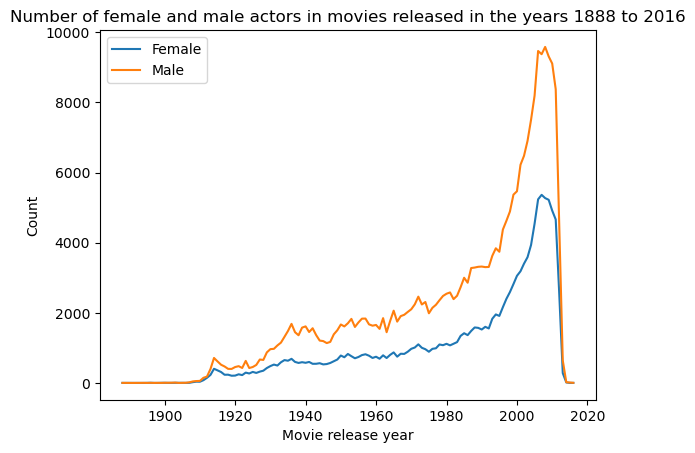

In [99]:
# Count
no_females = female_characters.groupby('Movie release year').size()
no_males = male_characters.groupby('Movie release year').size()

plt.plot(no_females)
plt.plot(no_males)
plt.title('Number of female and male actors in movies released in the years 1888 to 2016')
plt.xlabel('Movie release year')
plt.ylabel('Count')
plt.legend(['Female', 'Male'])
plt.show()

As we can see, there are generally fewer female actors in movies than male actors.

Next, we will explore the percentage of female characters in movies throughout the years. Firstly, we calculate the percentage of females for each movie and then take the average over each year. We then make a linear regression to see, if there is a change of percentage of female actors in movies over the years.

/Users/bruger/anaconda3/envs/ada/lib/python3.9/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


                                 OLS Regression Results                                 
Dep. Variable:     Percentage female characters   R-squared:                       0.273
Model:                                      OLS   Adj. R-squared:                  0.266
Method:                           Least Squares   F-statistic:                     44.59
Date:                          Wed, 06 Dec 2023   Prob (F-statistic):           8.17e-10
Time:                                  14:10:20   Log-Likelihood:                -456.54
No. Observations:                           121   AIC:                             917.1
Df Residuals:                               119   BIC:                             922.7
Df Model:                                     1                                         
Covariance Type:                      nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
-----------------------

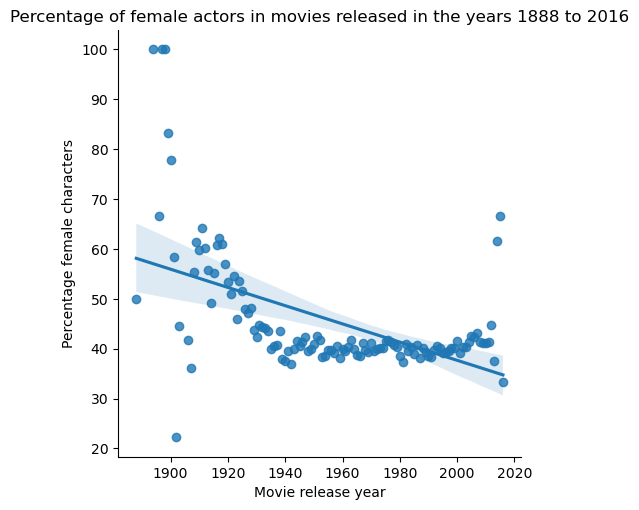

In [100]:
# Count number of female in each movie
female_count = female_characters.groupby('Wikipedia Movie ID').size()
male_count = male_characters.groupby('Wikipedia Movie ID').size()

# Ensure that all Wikipedia Movie IDs in 'female_count' are represented in 'male_count'
# Fill missing values with 0
male_count = male_count.reindex(female_count.index, fill_value=0)

# Calculate the percentage of female characters
percentage_female = (female_count / (female_count + male_count)) * 100

# Reset the index to have 'Wikipedia Movie ID' as a column
percentage_female = percentage_female.reset_index()

# Rename the columns for clarity
percentage_female.columns = ['Wikipedia Movie ID', 'Percentage female characters']

# Merge dataframes
percentage_female_with_year = pd.merge(percentage_female, movie_metadata, on='Wikipedia Movie ID', how='left')

# Calculate female percentage pr. year and make into a data frame with column 'Movie release year' and 'Percentage female characters'
percentage_female_per_year = percentage_female_with_year.groupby('Movie release year')['Percentage female characters'].mean()
percentage_female_per_year = percentage_female_per_year.reset_index(name="Percentage female characters")
percentage_female_per_year['Movie release year'] = pd.to_numeric(percentage_female_per_year['Movie release year'], errors='coerce').astype(float)

# Drop missing values
percentage_female_per_year = percentage_female_per_year.dropna()

sns.lmplot(x='Movie release year', y="Percentage female characters", data=percentage_female_per_year)

# Perform linear regression
X = percentage_female_per_year['Movie release year']
X = sm.add_constant(X)  # Add an intercept term
y = percentage_female_per_year["Percentage female characters"]

model = sm.OLS(y, X).fit()

# Print the regression summary
print(model.summary())

plt.title('Percentage of female actors in movies released in the years 1888 to 2016')
plt.show()

The plot and linear regression indicates, that there is a significant decline of female characters over the years. But looking at the plot, the ends have a very high variance. Let us take a look at the count of movies over the years.

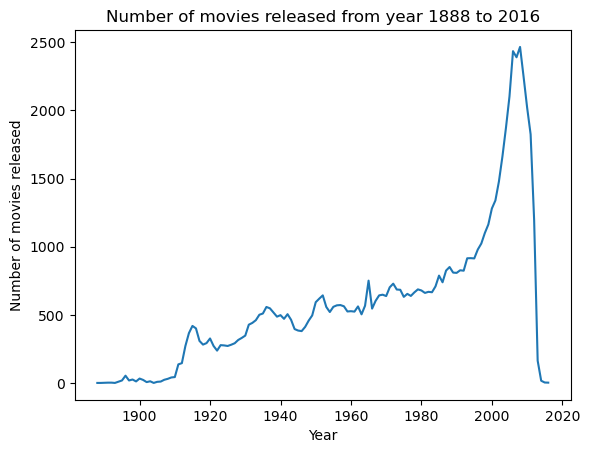

In [101]:
no_movies = movie_metadata.groupby('Movie release year').size()
plt.plot(no_movies)
plt.title('Number of movies released from year 1888 to 2016')
plt.xlabel('Year')
plt.ylabel('Number of movies released')
plt.show()

Since there isn't a lot of movies and the variance is very height in the 'end' years, we look at the progression of female characters from year 1940 to 2012.

/Users/bruger/anaconda3/envs/ada/lib/python3.9/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


                                 OLS Regression Results                                 
Dep. Variable:     Percentage female characters   R-squared:                       0.078
Model:                                      OLS   Adj. R-squared:                  0.065
Method:                           Least Squares   F-statistic:                     5.978
Date:                          Wed, 06 Dec 2023   Prob (F-statistic):             0.0170
Time:                                  14:11:04   Log-Likelihood:                -124.75
No. Observations:                            73   AIC:                             253.5
Df Residuals:                                71   BIC:                             258.1
Df Model:                                     1                                         
Covariance Type:                      nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
-----------------------

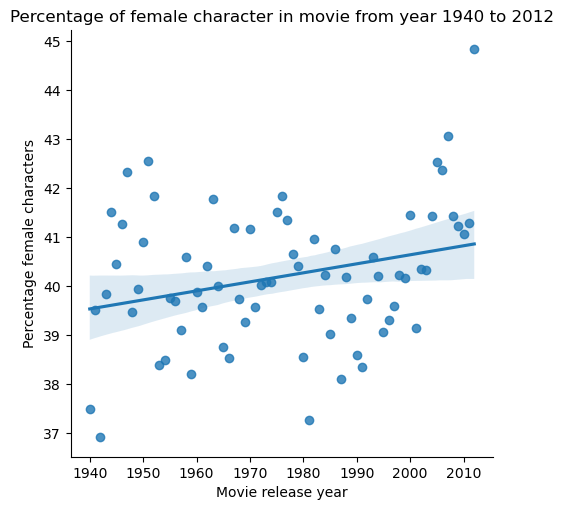

In [102]:
condition = (percentage_female_per_year['Movie release year'] < 1940) | (percentage_female_per_year['Movie release year'] > 2012)
percentage_female_per_year_filtered = percentage_female_per_year
percentage_female_per_year_filtered.loc[condition, 'Movie release year'] = np.nan
percentage_female_per_year_filtered = percentage_female_per_year_filtered.dropna()

sns.lmplot(x='Movie release year', y="Percentage female characters", data=percentage_female_per_year_filtered)

# Perform linear regression
X = percentage_female_per_year_filtered['Movie release year']
X = sm.add_constant(X)  # Add an intercept term
y = percentage_female_per_year_filtered["Percentage female characters"]

model = sm.OLS(y, X).fit()

# Print the regression summary
print(model.summary())

plt.title('Percentage of female character in movie from year 1940 to 2012')
plt.show()

The linear regression above indicates, that there is no decline, but rather an incline in female characters. However, the p-value = 0.017, so the incline is not significant with a .05 significance level.

### Gender's affect on box office revenue

We will now see if percentage of female characters have a significant correlation with **Movie box office revenue**. We will keep in mind, that we only have box office revenue for around 10% of the movies. However, this is still around 10'000 movies.

/Users/bruger/anaconda3/envs/ada/lib/python3.9/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


                                 OLS Regression Results                                 
Dep. Variable:     log Movie box office revenue   R-squared:                       0.013
Model:                                      OLS   Adj. R-squared:                  0.013
Method:                           Least Squares   F-statistic:                     123.9
Date:                          Wed, 06 Dec 2023   Prob (F-statistic):           1.37e-28
Time:                                  14:12:13   Log-Likelihood:                -20804.
No. Observations:                          9122   AIC:                         4.161e+04
Df Residuals:                              9120   BIC:                         4.163e+04
Df Model:                                     1                                         
Covariance Type:                      nonrobust                                         
                                   coef    std err          t      P>|t|      [0.025      0.975]
-------------

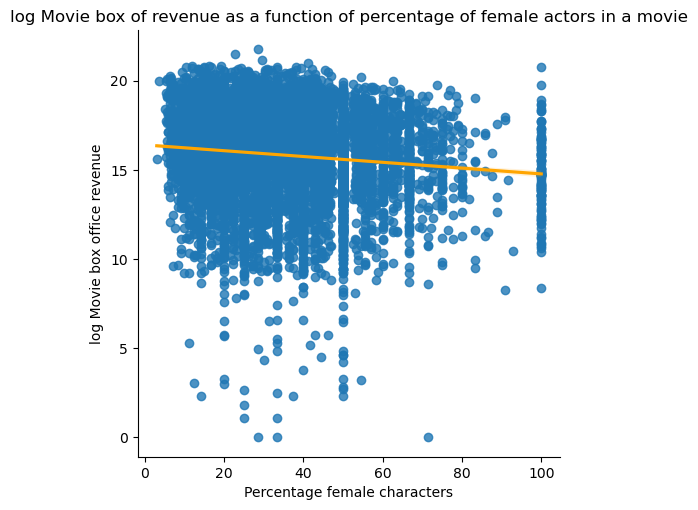

In [103]:
# Define dataframe with 'log Movie box office revenue' and 'Percentage female characters'
percentage_female_with_log_rev = percentage_female_with_year[['log Movie box office revenue', 'Percentage female characters']].dropna()

# Create a scatterplot with a regression line
sns.lmplot(x="Percentage female characters", y="log Movie box office revenue", data=percentage_female_with_log_rev, line_kws={'color': 'orange'})

# Perform linear regression
X = percentage_female_with_log_rev["Percentage female characters"]
X = sm.add_constant(X)  # Add an intercept term
y = percentage_female_with_log_rev["log Movie box office revenue"]

model = sm.OLS(y, X).fit()

# Print the regression summary
print(model.summary())

plt.title('log Movie box of revenue as a function of percentage of female actors in a movie')
plt.show()


The plot and linear regression indicates, that there is a significant decline in box office revenue, as the percentage of female characters increases.